In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',
              rc={'axes.facecolor': (0, 0, 0, 0)})
sns.set_context('paper')

from matplotlib import rcParams, colors, cm
import matplotlib.patches as mpatches
rcParams['font.family'] = 'sans-serif'
rcParams['figure.dpi'] = 150

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from scipy.integrate import trapezoid
import statsmodels.formula.api as smf
# local import
from utils import get_rbd_mutated

In [3]:
muts = {'epi-01': 'G446S',
'epi-02': 'L452Q',
'epi-03': 'L452R',
'epi-04': 'N460H',
'epi-05': 'F486I',
'epi-06': 'F486S',
'epi-07': 'F486V',
'epi-08': 'F490S',
'epi-09': 'F490P',
'epi-10': 'Q498R',
'epi-11': 'N501Y',
'epi-12': 'Q498R N501Y',
'epi-13': 'G446S N460H',
'epi-14': 'G446S F486I',
'epi-15': 'G446S F486S',
'epi-16': 'G446S F486V',
'epi-17': 'L452Q F490S',
'epi-18': 'L452R F490S',
'epi-19': 'L452R F490P',
'epi-20': 'G446S N460H Q498R N501Y',
'epi-21': 'G446S F486I Q498R N501Y',
'epi-22': 'G446S F486V Q498R N501Y',
'epi-23': 'F486V Q498R N501Y',
'epi-24': 'G446S F486S Q498R N501Y',
'epi-25': 'L452Q F490S Q498R N501Y',
'epi-26': 'L452R F490S Q498R N501Y',
'epi-27': 'L452R Q498R N501Y',
'epi-28': 'L452R F490P Q498R N501Y',
'epi-29': 'F490P Q498R N501Y'}

In [4]:
d_wt = {}
d_mut = {}
for epi, mut_str in muts.items():
    d_mut[epi] = {}
    for mut in mut_str.split():
        wt, pos, mu = mut[0], int(mut[1:-1]), mut[-1]
        d_wt[pos] = wt
        d_mut[epi][pos] = mu

In [5]:
genos = {}
WT_STR = ''.join([d_wt[k] for k in sorted(d_wt)])
genos['WT'] = WT_STR
for key, v in muts.items():
    genos[v] = ''.join([d_mut[key].get(k, d_wt[k]) for k in sorted(d_wt)])

In [6]:
def epi_model(n, m1, m2, target='fc'):
    df = pd.concat([n[n['kind'] == 'WT'],
                    n[(n[m1] == 1) & (n['kind'] == 'single')],
                    n[(n[m2] == 1) & (n['kind'] == 'single')],
                    n[(n[m1] == 1) & (n[m2] == 1) & (n['kind'] == 'double')]])
    df = df.rename(columns={m1: 'm1',
                            m2: 'm2'})
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=[target], how="all", inplace=True)
    res = smf.ols(f'{target} ~ replicate + m1 + m2 + m1:m2', data=df).fit()
    null = smf.ols(f'{target} ~ replicate + m1 + m2', data=df).fit()
    return res.rsquared, null.rsquared, res.compare_lr_test(null)[1]

def epi_model_498_501(n, m1, m2, target='fc'):
    df = pd.concat([n[n['kind'] == 'WT'],
                    n[(n[m1] == 1) & (n['kind'] == 'single')],
                    n[(n[m2] == 1) & (n['kind'] == 'single')],
                    n[(n[m1] == 1) & (n[m2] == 1) & (n['kind'] == 'double')],
                    n[(n[498] == 1) & (n['kind'] == 'single')],
                    n[(n[501] == 1) & (n['kind'] == 'single')],
                    n[(n[498] == 1) & (n[501] == 1) & (n['kind'] == 'double')],
                    n[(n[m1] == 1) & (n[m2] == 1) &
                      (n[498] == 1) & (n[501] == 1) & (n['kind'] == 'quadruple')]])
    df = df.rename(columns={m1: 'm1',
                            m2: 'm2',
                            498: 'm498',
                            501: 'm501'})
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=[target], how="all", inplace=True)
    res = smf.ols(f'{target} ~ replicate + m1 + m2 + m498 + m501 + m498:m501 + m1:m2', data=df).fit()
    null = smf.ols(f'{target} ~ replicate + m1 + m2 + m498 + m501 + m498:m501', data=df).fit()
    return res.rsquared, null.rsquared, res.compare_lr_test(null)[1]

In [7]:
def epi_model_specific(n, m1, m2, n1, n2, target='fc'):
    df = pd.concat([n[n['kind'] == 'WT'],
                    n[(n[m1] == 1) & (n['mutant'].str.contains(n1)) & (n['kind'] == 'single')],
                    n[(n[m2] == 1) & (n['mutant'].str.contains(n2)) & (n['kind'] == 'single')],
                    n[(n[m1] == 1) & (n[m2] == 1) & 
                      (n['mutant'].str.contains(n1)) & 
                      (n['mutant'].str.contains(n2)) &
                      (n['kind'] == 'double')]])
    df = df.rename(columns={m1: 'm1',
                            m2: 'm2'})
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=[target], how="all", inplace=True)
    res = smf.ols(f'{target} ~ replicate + m1 + m2 + m1:m2', data=df).fit()
    null = smf.ols(f'{target} ~ replicate + m1 + m2', data=df).fit()
    return res.rsquared, null.rsquared, res.compare_lr_test(null)[1]

def epi_model_specific_498_501(n, m1, m2, n1, n2, target='fc'):
    df = pd.concat([n[n['kind'] == 'WT'],
                    n[(n[m1] == 1) & (n['mutant'].str.contains(n1)) & (n['kind'] == 'single')],
                    n[(n[m2] == 1) & (n['mutant'].str.contains(n2)) & (n['kind'] == 'single')],
                    n[(n[m1] == 1) & (n[m2] == 1) &
                      (n['mutant'].str.contains(n1)) & 
                      (n['mutant'].str.contains(n2)) &
                      (n['kind'] == 'double')],
                    n[(n[498] == 1) & (n['kind'] == 'single')],
                    n[(n[501] == 1) & (n['kind'] == 'single')],
                    n[(n[498] == 1) & (n[501] == 1) & (n['kind'] == 'double')],
                    n[(n[m1] == 1) & (n[m2] == 1) &
                      (n['mutant'].str.contains(n1)) & 
                      (n['mutant'].str.contains(n2)) &
                      (n[498] == 1) & (n[501] == 1) & (n['kind'] == 'quadruple')]])
    df = df.rename(columns={m1: 'm1',
                            m2: 'm2',
                            498: 'm498',
                            501: 'm501'})
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=[target], how="all", inplace=True)
    res = smf.ols(f'{target} ~ replicate + m1 + m2 + m498 + m501 + m498:m501 + m1:m2', data=df).fit()
    null = smf.ols(f'{target} ~ replicate + m1 + m2 + m498 + m501 + m498:m501', data=df).fit()
    return res.rsquared, null.rsquared, res.compare_lr_test(null)[1]

In [8]:
def read_mi(fname, name='all', date=True):
    a = pd.read_csv(fname, sep='\t')

    # filtering
    #
    # 1. end of the genome
    # 2. same gene and same codon
    # 3. different gene and too close
    #
    a = a[((a['pos_source'] <= 29674) & (a['pos_target'] <= 29674)) &
          (((a['gene_source'] == a['gene_target']) &
            (a['feature_codon_source'] != a['feature_codon_target'])) |
           ((a['gene_source'] != a['gene_target'])))]

    a['name'] = name
    if date:
        a['year'] = int(name.split('-')[0])
        a['month'] = int(name.split('-')[1])

    return a

In [9]:
df = []
d_mutated = {}
all_mutated = set()
for name in sorted(os.listdir('../out/update/time-filtered-subsets/')):
    try:
        a = read_mi(f'../out/update/time-filtered-subsets/{name}/mi_annotated.tsv.gz',
                    name,
                    date=True)
        a = a[(a['gene_source'] == 'S') &
              (a['gene_target'] == 'S') &
              (a['feature_codon_source'] >= 319) &
              (a['feature_codon_source'] <= 540) &
              (a['feature_codon_target'] >= 319) &
              (a['feature_codon_target'] <= 540)]
        df.append(a)
        mutated = get_rbd_mutated('../out/update/time-filtered-lineages/',
                                  names=[name,])
        d_mutated[name] = mutated.union(all_mutated)
        all_mutated = mutated.union(all_mutated)
    except FileNotFoundError:
        pass
df = pd.concat(df)

In [10]:
LAST_DATE = df['name'].sort_values().values[-1]

LAST_DATE

'2023-08'

In [11]:
e = df[df['name'] == LAST_DATE].copy()

e['feature_codon_source'] = e['feature_codon_source'].astype(int)
e['feature_codon_target'] = e['feature_codon_target'].astype(int)

e = e[['feature_codon_source',
       'feature_codon_target',
       'mi', 'outlier']].copy()

In [12]:
e[(e['feature_codon_source'].isin([452, 486, 490, 460,
          498, 501, 446])) &
  (e['feature_codon_target'].isin([452, 486, 490, 460,
          498, 501, 446]))].head(4)

,feature_codon_source,feature_codon_target,mi,outlier
3533,446,460,0.52237,4
3534,446,486,0.46883,4
3535,452,490,0.48442,4
3541,498,501,0.12648,1


In [13]:
n = pd.read_csv('../data/20240307_neutralization.tsv', sep='\t',
                index_col=[0, 1])

n = n.stack().reset_index().rename(
    columns={'level_2': '[mAb]',
             0: 'infectivity'})
n['[mAb]'] = n['[mAb]'].astype(float)

n['mutant'] = n['mutant'].str.rstrip()

n['mutant'] = [muts.get(x.lower(), x)
               for x in n['mutant'].values]

n['replicate'] = [f'rep{x}' for x in n['replicate'].values]

In [14]:
for mut in {int(y[1:-1]) for x in n['mutant'].unique()
            for y in x.split()
            if y != 'WT'}:
    n[mut] = 0

for idx, rows in n.iterrows():
    if rows['mutant'] == 'WT':
        continue
    for mut in rows['mutant'].split():
        n.loc[idx, int(mut[1:-1])] = 1

In [15]:
def normalize(x):
    x['normalized'] = x['infectivity'] / x['infectivity'].max()
    x['normalized'] += 0.001
    return x
    
n = n.groupby(['mutant', 'replicate']
             ).apply(normalize).reset_index(drop=True)

/tmp/ipykernel_3485257/2926784755.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(normalize).reset_index(drop=True)


In [16]:
res = []
for x in n['mutant'].values:
    if x == 'WT':
        res.append('WT')
    elif ' ' not in x:
        res.append('single')
    elif len(x.split()) == 2:
        res.append('double')
    elif len(x.split()) == 3:
        res.append('triple')
    elif len(x.split()) == 4:
        res.append('quadruple')
    else:
        raise ValueError
n['kind'] = res

In [17]:
def get_auc(t, ymin):
    
    x = np.log(t['[mAb]'])
    x = - (x - x.min()) + abs((x - x.min()).max())
    y = np.log(t['normalized'])
    y = y - ymin

    df = pd.DataFrame([x,
                       y]).T.sort_values('[mAb]')
    df = df.groupby('[mAb]').mean().reset_index()
    
    t['auc'] = trapezoid(df['normalized'],
                         df['[mAb]'])

    return t

# t = n.groupby(['mutant',
#                'replicate',
#                452, 486, 490,
#                460, 498, 501,
#                446, 'kind', '[mAb]'])['normalized'].mean().reset_index()
a = n.groupby(['mutant', 'replicate']).apply(get_auc,
                                             ymin=np.log(n['normalized'].min())).reset_index(drop=True)
a = a.groupby(['mutant',
               'replicate',
               452, 486, 490,
               460, 498, 501,
               446, 'kind'])['auc'].max(
               ).reset_index()
# a['auc'] += abs(a['auc'].min()) + 0.001
a['log_auc'] = np.log(a['auc'])

def get_fc(x, max_auc):
    x['fc'] = x['auc'] / max_auc
    return x

x = np.log(n['[mAb]'].unique())
x = - (x - x.min()) + abs((x - x.min()).max())

y = [1 + 0.001] * x.shape[0]
y = np.log(y)
y = y - np.log(n['normalized'].min())

max_auc = trapezoid(y, x)

a = a.groupby('replicate').apply(get_fc, max_auc=max_auc).reset_index(drop=True)

a['auc'] = a['auc'] / max_auc

/tmp/ipykernel_3485257/2543837589.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  a = n.groupby(['mutant', 'replicate']).apply(get_auc,
/tmp/ipykernel_3485257/2543837589.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  a = a.groupby('replicate').apply(get_fc, max_auc=max_auc).reset_index(drop=True)


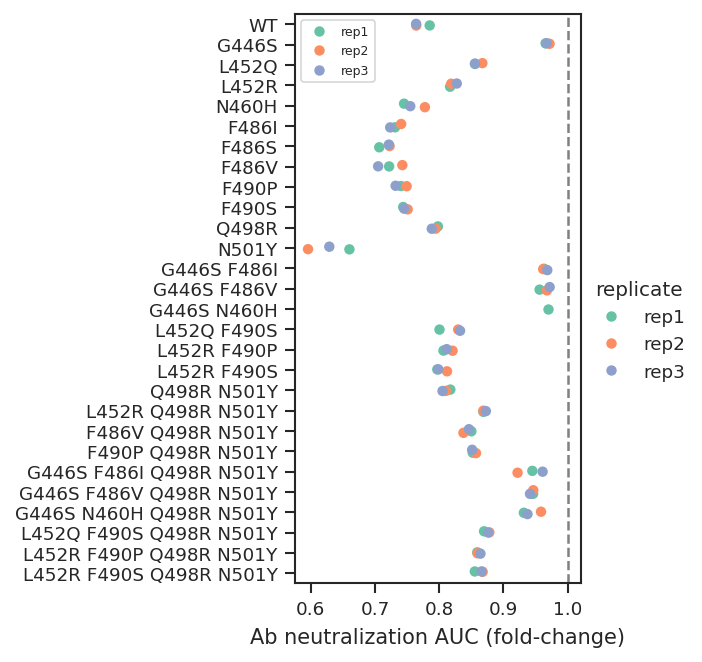

In [18]:
cp = sns.catplot(data=a,
                 order=['WT'] +
                       sorted(list(a[a['kind'] == 'single']['mutant'].unique()),
                              key=lambda x: int(x[1:-1])) +
                       sorted(list(a[a['kind'] == 'double']['mutant'].unique()),
                              key=lambda x: int(x.split()[0][1:-1])) +
                       sorted(list(a[a['kind'] == 'triple']['mutant'].unique()),
                              key=lambda x: int(x.split()[0][1:-1])) +
                       sorted(list(a[a['kind'] == 'quadruple']['mutant'].unique()),
                              key=lambda x: int(x.split()[0][1:-1])),
                 y='mutant', x='fc',
                 hue='replicate',
                 palette='Set2',
                 height=4.5)

ax = cp.axes[0][0]
ax.axvline(1, color='grey', ls='dashed',
            zorder=-1)
# ax.set_xticks([0, 0.5, 1, 1.5, 2, 2.5])
# ax.set_xlim(-0.1, 2.6)
ax.set_xlabel('Ab neutralization AUC (fold-change)',
              fontsize=10)
ax.set_ylabel('')
# ax.set_xscale('log', base=2)

plt.legend(facecolor='w',
           fontsize=6)

sns.despine(right=False,
            top=False)

# plt.savefig('wet_lab_1.png',
#             dpi=300,
#             bbox_inches='tight',
#             transparent=True)
# plt.savefig('wet_lab_1.svg',
#             dpi=300,
#             bbox_inches='tight',
#             transparent=True);
pass

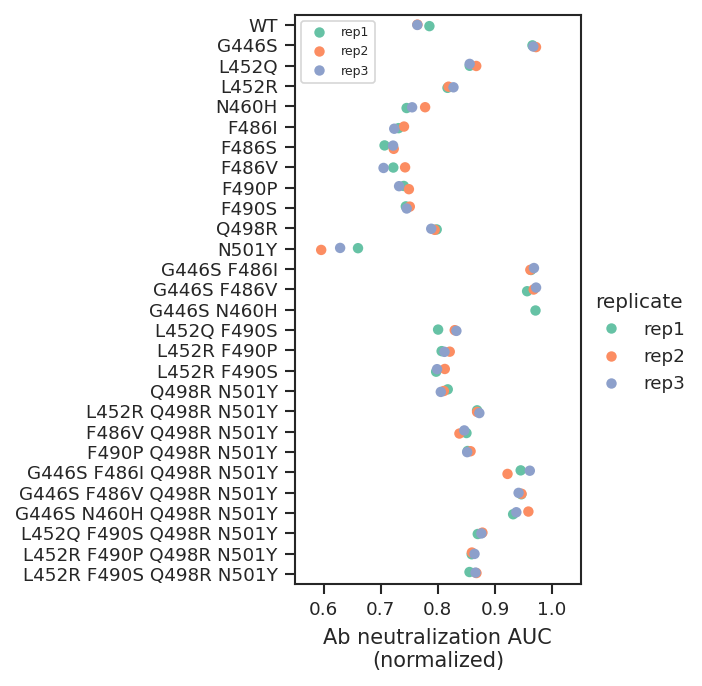

In [19]:
cp = sns.catplot(data=a,
                 order=['WT'] +
                       sorted(list(a[a['kind'] == 'single']['mutant'].unique()),
                              key=lambda x: int(x[1:-1])) +
                       sorted(list(a[a['kind'] == 'double']['mutant'].unique()),
                              key=lambda x: int(x.split()[0][1:-1])) +
                       sorted(list(a[a['kind'] == 'triple']['mutant'].unique()),
                              key=lambda x: int(x.split()[0][1:-1])) +
                       sorted(list(a[a['kind'] == 'quadruple']['mutant'].unique()),
                              key=lambda x: int(x.split()[0][1:-1])),
                 y='mutant', x='auc',
                 hue='replicate',
                 palette='Set2',
                 height=4.5)

ax = cp.axes[0][0]
# ax.axvline(1, color='grey', ls='dashed',
#             zorder=-1)
# ax.set_xticks([0, 0.5, 1, 1.5, 2, 2.5])
ax.set_xlim(0.55, 1.05)
ax.set_xlabel('Ab neutralization AUC\n(normalized)',
              fontsize=10)
ax.set_ylabel('')

plt.legend(facecolor='w',
           fontsize=6)

sns.despine(right=False,
            top=False)

plt.savefig('wet_lab_1.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('wet_lab_1.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

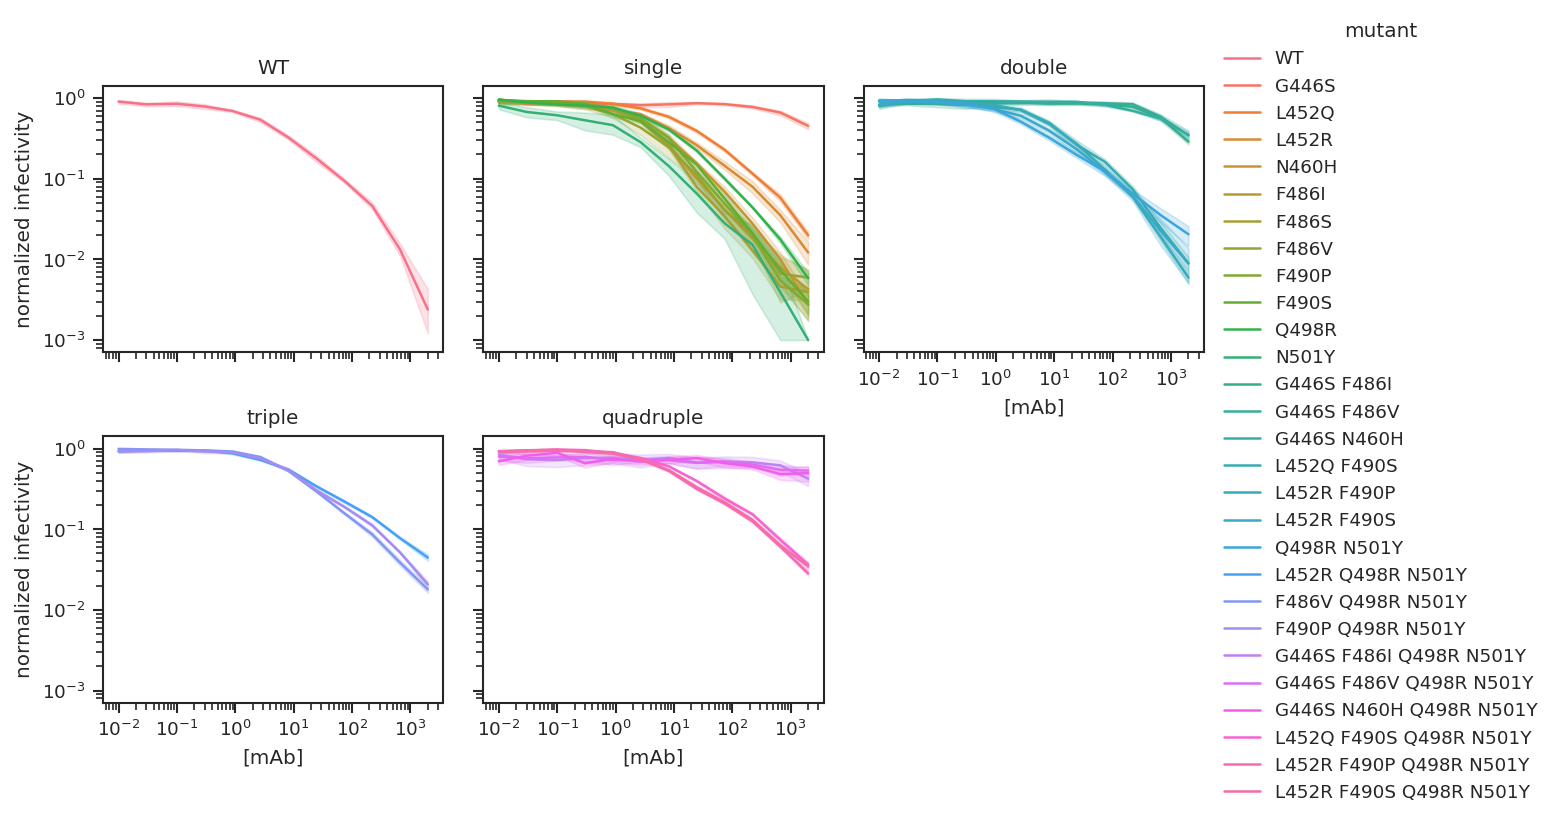

In [20]:
rp = sns.relplot(data=n,
                 x='[mAb]',
                 y='normalized',
                 hue='mutant',
                 kind='line',
                 col='kind',
                 col_wrap=3,
                 col_order=['WT', 'single',
                            'double', 'triple',
                            'quadruple'],
                 hue_order=['WT'] + sorted(list(a[a['kind'] == 'single']['mutant'].unique()),
                              key=lambda x: int(x[1:-1])) +
                       sorted(list(a[a['kind'] == 'double']['mutant'].unique()),
                              key=lambda x: int(x.split()[0][1:-1])) +
                       sorted(list(a[a['kind'] == 'triple']['mutant'].unique()),
                              key=lambda x: int(x.split()[0][1:-1])) +
                       sorted(list(a[a['kind'] == 'quadruple']['mutant'].unique()),
                              key=lambda x: int(x.split()[0][1:-1])),
                 height=2.5, aspect=1.1)

rp.set_titles("{col_name}")
rp.set(xscale='log',
       yscale='log',
       ylabel='normalized infectivity')

sns.despine(top=False,
            right=False)

plt.savefig('wet_lab_2.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('wet_lab_2.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

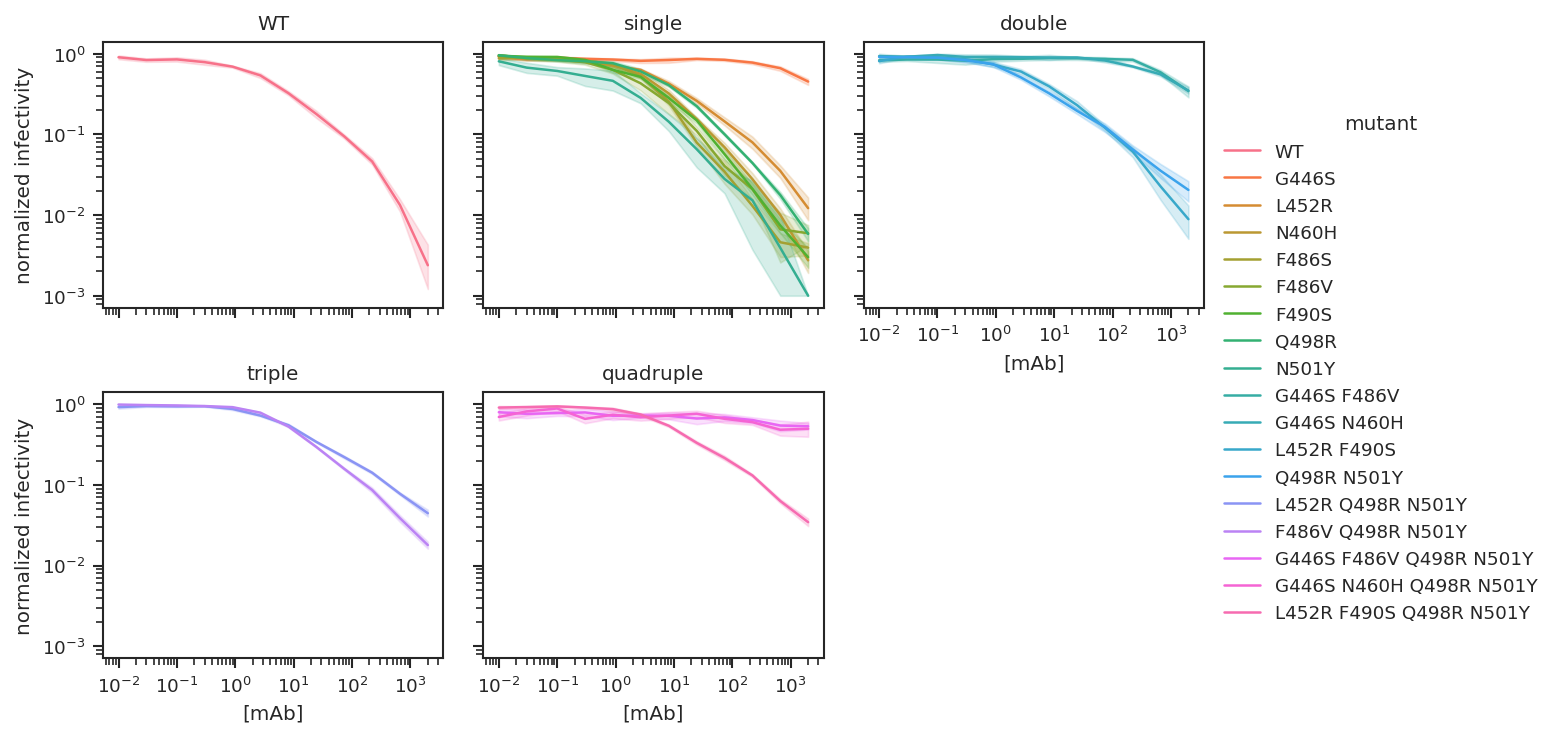

In [21]:
b = n[((n['mutant'].str.contains('G446S')) |
       (n['mutant'].str.contains('N460H')) |
       (n['mutant'].str.contains('F486S')) |
       (n['mutant'].str.contains('F486V')) |
       (n['mutant'].str.contains('L452R')) |
       (n['mutant'].str.contains('F490S')) |
       (n['mutant'].isin(['Q498R N501Y', 'Q498R', 'N501Y'])) |
       (n['mutant'].str.contains('WT'))) &
      (~n['mutant'].str.contains('F486I')) &
      (~n['mutant'].str.contains('L452Q')) &
      (~n['mutant'].str.contains('F490P'))].copy()

rp = sns.relplot(data=b,
                 x='[mAb]',
                 y='normalized',
                 hue='mutant',
                 kind='line',
                 col='kind',
                 col_wrap=3,
                 col_order=['WT', 'single',
                            'double', 'triple',
                            'quadruple'],
                 hue_order=['WT'] + sorted(list(b[b['kind'] == 'single']['mutant'].unique()),
                              key=lambda x: int(x[1:-1])) +
                       sorted(list(b[b['kind'] == 'double']['mutant'].unique()),
                              key=lambda x: int(x.split()[0][1:-1])) +
                       sorted(list(b[b['kind'] == 'triple']['mutant'].unique()),
                              key=lambda x: int(x.split()[0][1:-1])) +
                       sorted(list(b[b['kind'] == 'quadruple']['mutant'].unique()),
                              key=lambda x: int(x.split()[0][1:-1])),
                 height=2.5, aspect=1.1)

rp.set_titles("{col_name}")
rp.set(xscale='log',
       yscale='log',
       ylabel='normalized infectivity')

sns.despine(top=False,
            right=False)

plt.savefig('wet_lab_2a.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('wet_lab_2a.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [22]:
print(epi_model(a, 498, 501, target='auc'))

(0.9810677704256449, 0.6853862074854531, 6.345478395950745e-09)


In [23]:
print(epi_model_specific(a, 498, 501, 'Q498R', 'N501Y', target='auc'))

(0.9810677704256449, 0.6853862074854531, 6.345478395950745e-09)


In [24]:
print(epi_model(a, 446, 460, target='auc'), epi_model_498_501(a, 446, 460, target='auc'))

(0.9926139203552932, 0.991748852424046, 0.2926147282265944) (0.9809489333197038, 0.9805531146897246, 0.5011954650967341)


In [25]:
print(epi_model_specific(a, 446, 460, 'G446S', 'N460H', target='auc'), epi_model_specific_498_501(a, 446, 460, 'G446S', 'N460H', target='auc'))

(0.9926139203552932, 0.991748852424046, 0.2926147282265944) (0.9809489333197038, 0.9805531146897246, 0.5011954650967341)


In [26]:
print(epi_model(a, 446, 486, target='auc'), epi_model_498_501(a, 446, 486, target='auc'))

(0.9941996876141609, 0.986918715155546, 3.5862522956085706e-05) (0.9827893950040091, 0.9762610418902345, 0.0006676171665358426)


In [27]:
print(epi_model_specific(a, 446, 486, 'G446S', 'F486S', target='auc'), epi_model_specific_498_501(a, 446, 486, 'G446S', 'F486S', target='auc'))

(0.9955232718237759, 0.9955232718237759, nan) (0.9887464619724063, 0.9887464619724063, nan)


In [28]:
print(epi_model_specific(a, 446, 486, 'G446S', 'F486V', target='auc'), epi_model_specific_498_501(a, 446, 486, 'G446S', 'F486V', target='auc'))

(0.9934551202238097, 0.9832414634357964, 0.0007823282402799843) (0.9825147781645849, 0.9778428250299495, 0.017126856520870554)


In [29]:
print(epi_model(a, 452, 490, target='auc'), epi_model_498_501(a, 452, 490, target='auc'))

(0.8910324735840318, 0.891017223966382, 0.9537865512628847) (0.9573666661185347, 0.9572198284433818, 0.7039377916630747)


In [30]:
print(epi_model_specific(a, 452, 490, 'L452R', 'F490S', target='auc'), epi_model_specific_498_501(a, 452, 490, 'L452R', 'F490S', target='auc'))

(0.9505214191469242, 0.9478924952345815, 0.43059079438065007) (0.9729361183908632, 0.9726809189589399, 0.6350698479121749)


In [31]:
b = a[((a['mutant'].str.contains('L452R')) |
       (a['mutant'].str.contains('F490S')) |
       (a['mutant'].str.contains('G446S')) |
       (a['mutant'].str.contains('N460H')) |
       (a['mutant'].str.contains('F486S')) |
       (a['mutant'].str.contains('F486V')) |
       (a['mutant'].isin(['Q498R N501Y', 'Q498R', 'N501Y'])) |
       (a['mutant'].str.contains('WT'))) &
      (~a['mutant'].str.contains('F486I')) &
      (~a['mutant'].str.contains('L452Q')) &
      (~a['mutant'].str.contains('F490P'))].copy()

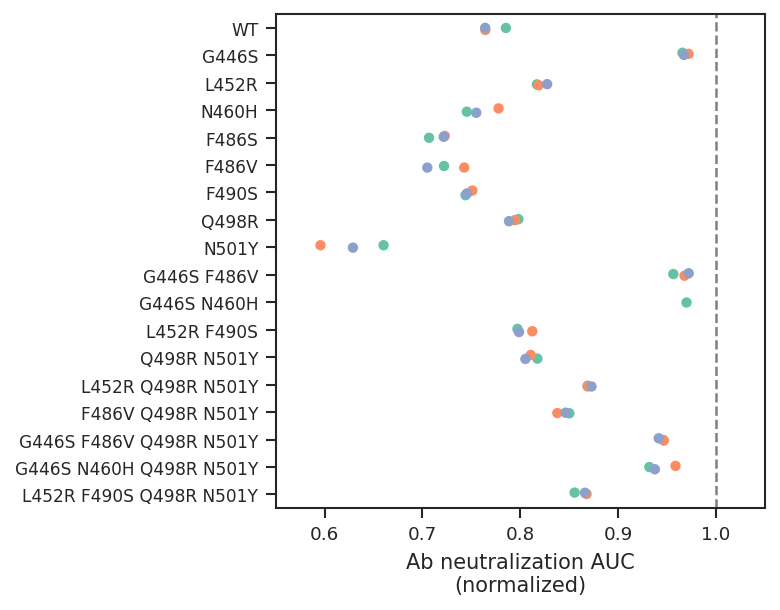

In [32]:
mut_order = ['WT'] + sorted(list(b[b['kind'] == 'single']['mutant'].unique()),
            key=lambda x: int(x[1:-1])) + sorted(list(b[b['kind'] == 'double']['mutant'].unique()),
            key=lambda x: int(x.split()[0][1:-1])) + sorted(list(b[b['kind'] == 'triple']['mutant'].unique()),
            key=lambda x: int(x.split()[0][1:-1])) + sorted(list(b[b['kind'] == 'quadruple']['mutant'].unique()),
            key=lambda x: int(x.split()[0][1:-1]))

cp = sns.catplot(data=b,
                 order=mut_order,
                 y='mutant', x='auc',
                 hue='replicate',
                 palette='Set2',
                 height=4, aspect=1.4, legend=None)

ax = cp.axes[0][0]
ax.axvline(1, color='grey', ls='dashed',
            zorder=-1)
# ax.set_xticks([0, 0.5, 1, 1.5, 2, 2.5])
ax.set_xlim(0.55, 1.05)
ax.set_xlabel('Ab neutralization AUC\n(normalized)',
              fontsize=10)
ax.set_ylabel('')
ax.set_yticks(range(len(mut_order)),
              mut_order, fontsize=8.2)

# plt.legend(facecolor='w',
#            fontsize=6)

sns.despine(right=False,
            top=False)

plt.savefig('wet_lab_ab.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('wet_lab_ab.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

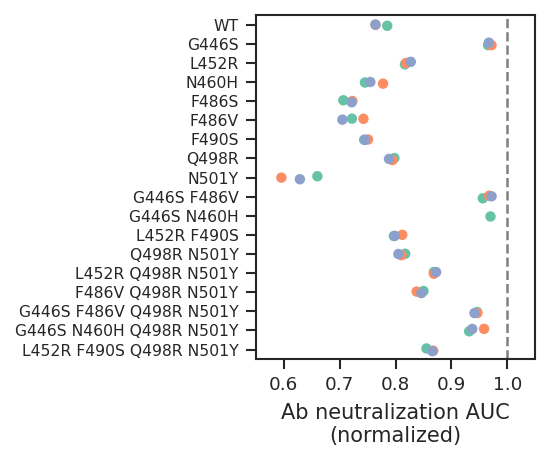

In [33]:
mut_order = ['WT'] + sorted(list(b[b['kind'] == 'single']['mutant'].unique()),
            key=lambda x: int(x[1:-1])) + sorted(list(b[b['kind'] == 'double']['mutant'].unique()),
            key=lambda x: int(x.split()[0][1:-1])) + sorted(list(b[b['kind'] == 'triple']['mutant'].unique()),
            key=lambda x: int(x.split()[0][1:-1])) + sorted(list(b[b['kind'] == 'quadruple']['mutant'].unique()),
            key=lambda x: int(x.split()[0][1:-1]))

cp = sns.catplot(data=b,
                 order=mut_order,
                 y='mutant', x='auc',
                 hue='replicate',
                 palette='Set2',
                 height=3, aspect=1.4, legend=None)

ax = cp.axes[0][0]
ax.axvline(1, color='grey', ls='dashed',
            zorder=-1)
# ax.set_xticks([0, 0.5, 1, 1.5, 2, 2.5])
ax.set_xlim(0.55, 1.05)
ax.set_xlabel('Ab neutralization AUC\n(normalized)',
              fontsize=10)
ax.set_ylabel('')
ax.set_yticks(range(len(mut_order)),
              mut_order, fontsize=7.5)

# plt.legend(facecolor='w',
#            fontsize=6)

sns.despine(right=False,
            top=False)

plt.savefig('wet_lab_ab_446_b.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('wet_lab_ab_446_b.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

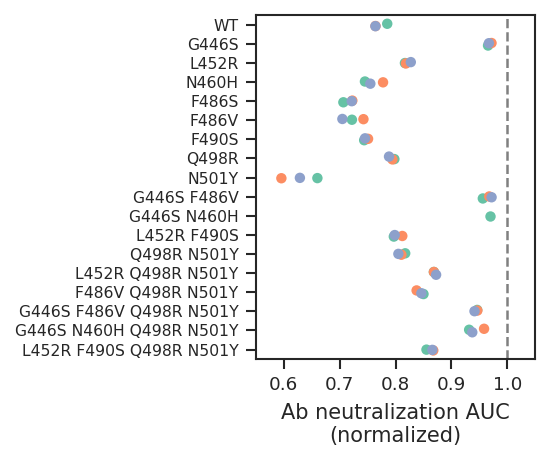

In [34]:
mut_order = ['WT'] + sorted(list(b[b['kind'] == 'single']['mutant'].unique()),
            key=lambda x: int(x[1:-1])) + sorted(list(b[b['kind'] == 'double']['mutant'].unique()),
            key=lambda x: int(x.split()[0][1:-1])) + sorted(list(b[b['kind'] == 'triple']['mutant'].unique()),
            key=lambda x: int(x.split()[0][1:-1])) + sorted(list(b[b['kind'] == 'quadruple']['mutant'].unique()),
            key=lambda x: int(x.split()[0][1:-1]))

cp = sns.catplot(data=b,
                 order=mut_order,
                 y='mutant', x='auc',
                 hue='replicate',
                 palette='Set2',
                 height=3, aspect=1.4, legend=None)

ax = cp.axes[0][0]
ax.axvline(1, color='grey', ls='dashed',
            zorder=-1)
# ax.set_xticks([0, 0.5, 1, 1.5, 2, 2.5])
ax.set_xlim(0.55, 1.05)
ax.set_xlabel('Ab neutralization AUC\n(normalized)',
              fontsize=10)
ax.set_ylabel('')
ax.set_yticks(range(len(mut_order)),
              mut_order, fontsize=7.5)

# plt.legend(facecolor='w',
#            fontsize=6)

sns.despine(right=False,
            top=False)

plt.savefig('wet_lab_ab_452_b.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('wet_lab_ab_452_b.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [35]:
n = pd.read_csv('../data/20240307_infectivity.tsv', sep='\t')

In [36]:
n['mutant'] = n['mutant'].str.rstrip()

n['mutant'] = [muts.get(x.lower(), x)
               for x in n['mutant'].values]

n['replicate'] = [f'rep{x}' for x in n['replicate'].values]

In [37]:
n = n.set_index(['mutant', 'replicate']).stack().reset_index().rename(columns={'level_2': 'ffu/well',
                                                                               0: 'count'})
n['ffu/well'] = n['ffu/well'].astype(float)

In [38]:
n['ffu/ml'] = n['ffu/well'] * 10
n['normalized'] = n['count'] * n['ffu/ml']

def get_fc(x):
    x['fc'] = np.log2(x['normalized'] / x[x['mutant'] == 'WT']['normalized'].mean())
    x['fc'] = [0 if np.isnan(x) else x
               for x in x['fc'].values]
    return x

n = n.groupby('replicate').apply(get_fc).reset_index(drop=True)

res = []
for x in n['mutant'].values:
    if x == 'WT':
        res.append('WT')
    elif ' ' not in x:
        res.append('single')
    elif len(x.split()) == 2:
        res.append('double')
    elif len(x.split()) == 3:
        res.append('triple')
    elif len(x.split()) == 4:
        res.append('quadruple')
    else:
        raise ValueError
n['kind'] = res

/home/marco/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_3485257/2375771042.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  n = n.groupby('replicate').apply(get_fc).reset_index(drop=True)


In [39]:
for mut in {int(y[1:-1]) for x in n['mutant'].unique()
            for y in x.split()
            if y != 'WT'}:
    n[mut] = 0

for idx, rows in n.iterrows():
    if rows['mutant'] == 'WT':
        continue
    for mut in rows['mutant'].split():
        n.loc[idx, int(mut[1:-1])] = 1

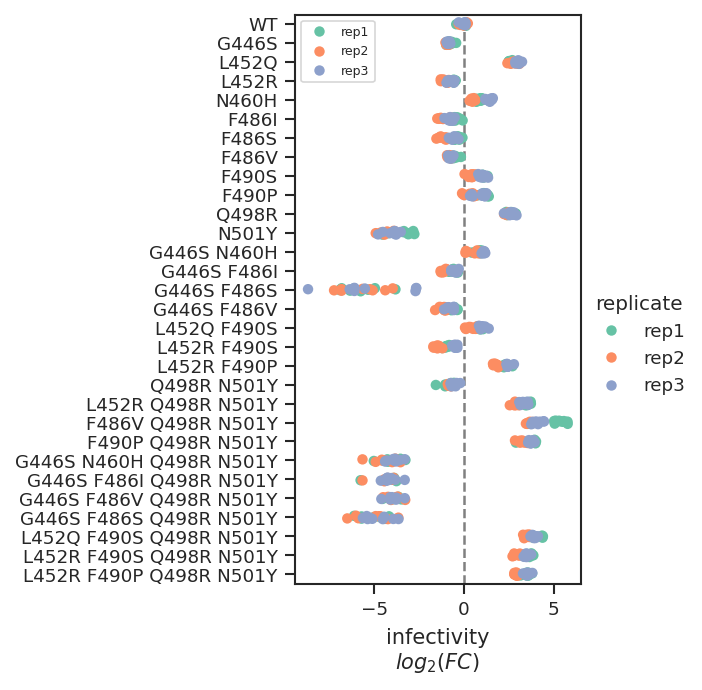

In [40]:
cp = sns.catplot(data=n,
                 order=['WT'] +
                       sorted(list(n[n['kind'] == 'single']['mutant'].unique()),
                              key=lambda x: int(x[1:-1])) +
                       sorted(list(n[n['kind'] == 'double']['mutant'].unique()),
                              key=lambda x: int(x.split()[0][1:-1])) +
                       sorted(list(n[n['kind'] == 'triple']['mutant'].unique()),
                              key=lambda x: int(x.split()[0][1:-1])) +
                       sorted(list(n[n['kind'] == 'quadruple']['mutant'].unique()),
                              key=lambda x: int(x.split()[0][1:-1])),
                 y='mutant', x='fc',
                 hue='replicate',
                 palette='Set2',
                 height=4.5)

ax = cp.axes[0][0]
ax.axvline(0, color='grey', ls='dashed',
            zorder=-1)
# ax.set_xticks([0, 0.5, 1, 1.5, 2, 2.5])
# ax.set_xlim(-0.1, 2.6)
ax.set_xlabel('infectivity\n$log_{2}(FC)$',
              fontsize=10)
ax.set_ylabel('')
# ax.set_xscale('log', base=2)

plt.legend(facecolor='w',
           fontsize=6)

sns.despine(right=False,
            top=False)

plt.savefig('wet_lab_3.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('wet_lab_3.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [41]:
print(epi_model(n, 498, 501))

(0.9807473850209866, 0.9758010198564031, 6.71348968128678e-07)


In [42]:
print(epi_model_specific(n, 498, 501, 'Q498R', 'N501Y'))

(0.9807473850209866, 0.9758010198564031, 6.71348968128678e-07)


In [43]:
print(epi_model(n, 446, 460), epi_model_498_501(n, 446, 460))

(0.9197657986875282, 0.8653598231459868, 7.598746240933224e-14) (0.8664628319678819, 0.8631813145601605, 0.02202543631645139)


In [44]:
print(epi_model_specific(n, 446, 460, 'G446S', 'N460H'), epi_model_specific_498_501(n, 446, 460, 'G446S', 'N460H'))

(0.9197657986875282, 0.8653598231459868, 7.598746240933224e-14) (0.8664628319678819, 0.8631813145601605, 0.02202543631645139)


In [45]:
print(epi_model(n, 446, 486), epi_model_498_501(n, 446, 486))

(0.271439779193858, 0.2614798977677971, 0.08752703777768922) (0.7287878257793383, 0.7275452484468159, 0.18926793602202246)


In [46]:
print(epi_model_specific(n, 446, 486, 'G446S', 'F486S'), epi_model_specific_498_501(n, 446, 486, 'G446S', 'F486S'))

(0.8972748408088437, 0.709604545026997, 5.36827457298782e-26) (0.936552748123338, 0.8668863478207267, 1.5980014079742814e-36)


In [47]:
print(epi_model_specific(n, 446, 486, 'G446S', 'F486V'), epi_model_specific_498_501(n, 446, 486, 'G446S', 'F486V'))

(0.8150745437564444, 0.6522632693763155, 1.4763365132019573e-16) (0.9378662052146157, 0.9344374244165948, 0.0006586535782444718)


In [48]:
print(epi_model(n, 452, 490), epi_model_498_501(n, 452, 490))

(0.08565818910336842, 0.040431058573430545, 0.001240913204308096) (0.724318040785874, 0.6930149796240832, 1.8168646269977157e-10)


In [49]:
print(epi_model_specific(n, 452, 490, 'L452R', 'F490S'), epi_model_specific_498_501(n, 452, 490, 'L452R', 'F490S'))

(0.9166910675532045, 0.802384427301431, 4.523708845606548e-22) (0.8068039687319408, 0.7991633681851569, 0.0037981793128186348)


In [50]:
d_wt = {}
d_mut = {}
for epi, mut_str in muts.items():
    d_mut[epi] = {}
    for mut in mut_str.split():
        wt, pos, mu = mut[0], int(mut[1:-1]), mut[-1]
        d_wt[pos] = wt
        d_mut[epi][pos] = mu

In [51]:
genos = {}
WT_STR = ''.join([d_wt[k] for k in sorted(d_wt)])
genos['WT'] = WT_STR
for key, v in muts.items():
    genos[v] = ''.join([d_mut[key].get(k, d_wt[k]) for k in sorted(d_wt)])

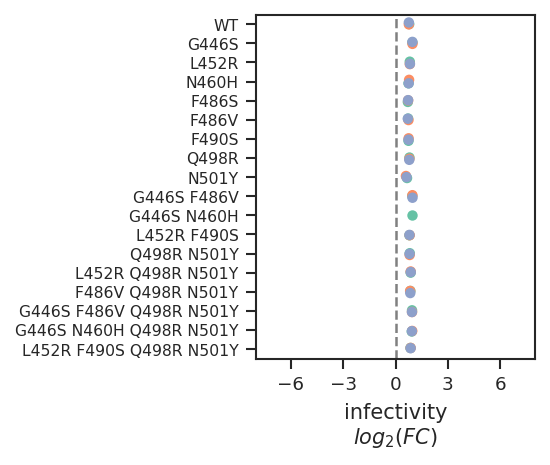

In [52]:
mut_order = ['WT'] + sorted(list(b[b['kind'] == 'single']['mutant'].unique()),
            key=lambda x: int(x[1:-1])) + sorted(list(b[b['kind'] == 'double']['mutant'].unique()),
            key=lambda x: int(x.split()[0][1:-1])) + sorted(list(b[b['kind'] == 'triple']['mutant'].unique()),
            key=lambda x: int(x.split()[0][1:-1])) + sorted(list(b[b['kind'] == 'quadruple']['mutant'].unique()),
            key=lambda x: int(x.split()[0][1:-1]))

cp = sns.catplot(data=b,
                 order=mut_order,
                 y='mutant', x='fc',
                 hue='replicate',
                 palette='Set2',
                 height=3, aspect=1.4, legend=None)

ax = cp.axes[0][0]
ax.axvline(0, color='grey', ls='dashed',
            zorder=-1)
ax.set_xticks([-6, -3, 0, 3, 6])
ax.set_xlim(-8, 8)
ax.set_xlabel('infectivity\n$log_{2}(FC)$',
              fontsize=10)
ax.set_ylabel('')
ax.set_yticks(range(len(mut_order)),
              mut_order, fontsize=7.5)
# ax.set_xscale('log', base=2)

# plt.legend(facecolor='w',
#            fontsize=6)

sns.despine(right=False,
            top=False)

plt.savefig('wet_lab_in_446_a.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('wet_lab_in_446_a.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [53]:
b = n[((n['mutant'].str.contains('L452R')) |
       (n['mutant'].str.contains('F490S')) |
       (n['mutant'].isin(['Q498R N501Y', 'Q498R', 'N501Y'])) |
       (n['mutant'].str.contains('WT'))) &
       (~n['mutant'].str.contains('L452Q')) &
       (~n['mutant'].str.contains('F490P'))].copy()

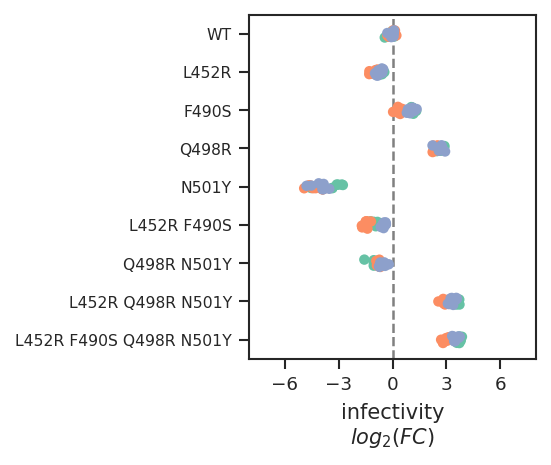

In [54]:
mut_order = ['WT'] + sorted(list(b[b['kind'] == 'single']['mutant'].unique()),
            key=lambda x: int(x[1:-1])) + sorted(list(b[b['kind'] == 'double']['mutant'].unique()),
            key=lambda x: int(x.split()[0][1:-1])) + sorted(list(b[b['kind'] == 'triple']['mutant'].unique()),
            key=lambda x: int(x.split()[0][1:-1])) + sorted(list(b[b['kind'] == 'quadruple']['mutant'].unique()),
            key=lambda x: int(x.split()[0][1:-1]))

cp = sns.catplot(data=b,
                 order=mut_order,
                 y='mutant', x='fc',
                 hue='replicate',
                 palette='Set2',
                 height=3, aspect=1.4, legend=None)

ax = cp.axes[0][0]
ax.axvline(0, color='grey', ls='dashed',
            zorder=-1)
ax.set_xticks([-6, -3, 0, 3, 6])
ax.set_xlim(-8, 8)
ax.set_xlabel('infectivity\n$log_{2}(FC)$',
              fontsize=10)
ax.set_ylabel('')
ax.set_yticks(range(len(mut_order)),
              mut_order, fontsize=7.5)
# ax.set_xscale('log', base=2)

# plt.legend(facecolor='w',
#            fontsize=6)

sns.despine(right=False,
            top=False)

plt.savefig('wet_lab_in_452_a.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('wet_lab_in_452_a.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [55]:
b = n[((n['mutant'].str.contains('L452R')) |
       (n['mutant'].str.contains('F490S')) |
       (n['mutant'].str.contains('G446S')) |
       (n['mutant'].str.contains('N460H')) |
       (n['mutant'].str.contains('F486S')) |
       (n['mutant'].str.contains('F486V')) |
       (n['mutant'].isin(['Q498R N501Y', 'Q498R', 'N501Y'])) |
       (n['mutant'].str.contains('WT'))) &
      (~n['mutant'].str.contains('F486I')) &
      (~n['mutant'].str.contains('L452Q')) &
      (~n['mutant'].str.contains('F490P'))].copy()

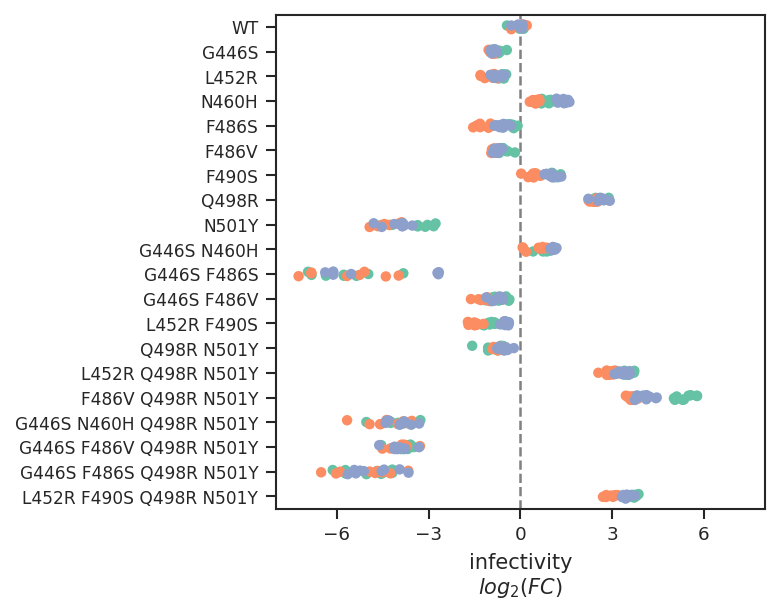

In [56]:
mut_order = ['WT'] + sorted(list(b[b['kind'] == 'single']['mutant'].unique()),
            key=lambda x: int(x[1:-1])) + sorted(list(b[b['kind'] == 'double']['mutant'].unique()),
            key=lambda x: int(x.split()[0][1:-1])) + sorted(list(b[b['kind'] == 'triple']['mutant'].unique()),
            key=lambda x: int(x.split()[0][1:-1])) + sorted(list(b[b['kind'] == 'quadruple']['mutant'].unique()),
            key=lambda x: int(x.split()[0][1:-1]))

cp = sns.catplot(data=b,
                 order=mut_order,
                 y='mutant', x='fc',
                 hue='replicate',
                 palette='Set2',
                 height=4, aspect=1.4, legend=None)

ax = cp.axes[0][0]
ax.axvline(0, color='grey', ls='dashed',
            zorder=-1)
ax.set_xticks([-6, -3, 0, 3, 6])
ax.set_xlim(-8, 8)
ax.set_xlabel('infectivity\n$log_{2}(FC)$',
              fontsize=10)
ax.set_ylabel('')
ax.set_yticks(range(len(mut_order)),
              mut_order, fontsize=8.2)
# ax.set_xscale('log', base=2)

# plt.legend(facecolor='w',
#            fontsize=6)

sns.despine(right=False,
            top=False)

plt.savefig('wet_lab_in.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('wet_lab_in.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);